In [8]:
# Setup and imports
%matplotlib inline

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import pymc3 as pm

import seaborn as sns

from src.data import make_dataset
from src.features import build_features
from src.models import train_model

In [9]:
df = make_dataset.make_dataset()

Dropping 32/185 countries due to lack of data


In [10]:
build_features.build_features(df)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, Afghanistan to Zimbabwe
Data columns (total 19 columns):
cases                                    153 non-null int64
deaths                                   153 non-null int64
death_rate_observed                      153 non-null float64
days_since_first_case                    153 non-null int64
cpi_score_2019                           153 non-null float64
healthcare_oop_expenditure               153 non-null float64
hospital_beds                            141 non-null float64
hci                                      137 non-null float64
population_perc_over65                   153 non-null float64
population_perc_rural                    153 non-null float64
population_perc_diabetic                 153 non-null float64
days_since_first_case_normalized         153 non-null float64
cpi_score_2019_normalized                153 non-null float64
healthcare_oop_expenditure_normalized    153 non-null float64
hospital_beds_normalize

### Missing data

Noticed in the above that `hci` and `hospital_beds` had missing data, which could be causing the issues with model initialization. My assumption is that we are seeing this now because countries which weren't reporting COVID-19 before are now, and those countries lack World Bank info on those two covariates.

In [42]:
full_covariates = [x for x in df.columns if 'normalized' in x]

In [43]:
covariates = list(set(full_covariates) - set(['hospital_beds_normalized','hci_normalized']))

In [108]:
def initialize_model(df, covariates):

    NUM_COVARIATES = len(covariates)
    
    n = len(df)

    covid_mortality_model = pm.Model()

    with covid_mortality_model:

        # Priors:
        mu_0 = pm.Beta('mu_0', alpha=0.3, beta=10)
#         sig_0 = pm.Uniform('sig_0', lower=0.0, upper=mu_0 * (1 - mu_0))
        beta = pm.Normal('beta', mu=0, sigma=5, shape=NUM_COVARIATES)
        sigma = pm.HalfNormal('sigma', sigma=5)

#         # Model mu from country-wise covariates:
#         # Apply logit transformation so logistic regression performed
        mu_0_logit = np.log(mu_0 / (1 - mu_0))
        mu_est = mu_0_logit + pm.math.dot(df[covariates].values, beta)
#         mu_est = mu_0_logit
# #         mu_est = mu_0_logit + \
# #             beta[0] * df['days_since_first_case_normalized'].values + \
# #             beta[1] * df['cpi_score_2019_normalized'].values + \
# #             beta[2] * df['healthcare_oop_expenditure_normalized'].values + \
# #             beta[3] * df['hospital_beds_normalized'].values + \
# #             beta[4] * df['hci_normalized'].values + \
# #             beta[3] * df['population_perc_over65_normalized'].values + \
# #             beta[4] * df['population_perc_rural_normalized'].values + \
# #             beta[5] * df['population_perc_diabetic'].values 
            
        mu_model_logit = pm.Normal('mu_model_logit',
                                   mu=mu_est,
                                   sigma=sigma,
                                   shape=n)
        # Transform back to probability space:
        mu_model = np.exp(mu_model_logit) / (np.exp(mu_model_logit) + 1)

        # tau_i, mortality rate for each country
        # Parametrize with (mu, sigma)
        # instead of (alpha, beta) to ease interpretability.
#         tau = pm.Beta('tau', mu=mu_model, sigma=sig_0, shape=n)
#         mu_model = pm.Uniform('mu_model', lower=0, upper=5)
#         tau = pm.Beta('tau', alpha=mu_model, beta=0.1, shape=n)

        # tau = pm.Beta('tau', mu=mu_0, sigma=sig_0, shape=n)

        # Binomial likelihood:
#         d_obs = pm.Binomial('d_obs',
#                             n=df['cases'].values,
#                             p=tau,
#                             observed=df['deaths'].values)
        d_obs = pm.Binomial('d_obs',
                            n=df['cases'].values,
                            p=mu_model,
                            observed=df['deaths'].values)

    return covid_mortality_model

In [109]:
model = initialize_model(df, covariates)

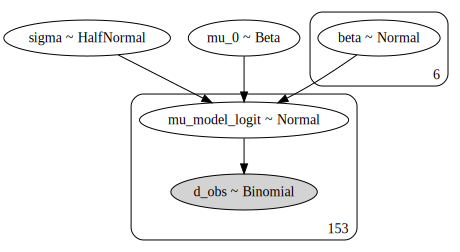

In [110]:
## In order to run this, you will need to brew install graphviz on your machine (for Mac users)
pm.model_to_graphviz(model)

In [111]:
trace = train_model.train_model(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_model_logit, sigma, beta, mu_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 379.46draws/s]
The acceptance probability does not match the target. It is 0.8808912370855281, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809225012107533, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913995700712355, but should be close to 0.8. Try to increase the number of tuning steps.


In [116]:
def initialize_model_2(df, covariates):

    NUM_COVARIATES = len(covariates)
    
    n = len(df)

    covid_mortality_model = pm.Model()

    with covid_mortality_model:

        # Priors:
        mu_0 = pm.Beta('mu_0', alpha=0.3, beta=10)
        sig_0 = pm.Uniform('sig_0', lower=0.0, upper=mu_0 * (1 - mu_0))
        beta = pm.Normal('beta', mu=0, sigma=5, shape=NUM_COVARIATES)
        sigma = pm.HalfNormal('sigma', sigma=5)

#         # Model mu from country-wise covariates:
#         # Apply logit transformation so logistic regression performed
        mu_0_logit = np.log(mu_0 / (1 - mu_0))
        mu_est = mu_0_logit + pm.math.dot(df[covariates].values, beta)
            
        mu_model_logit = pm.Normal('mu_model_logit',
                                   mu=mu_est,
                                   sigma=sigma,
                                   shape=n)
        # Transform back to probability space:
        mu_model = np.exp(mu_model_logit) / (np.exp(mu_model_logit) + 1)

        # tau_i, mortality rate for each country
        # Parametrize with (mu, sigma)
        # instead of (alpha, beta) to ease interpretability.
        tau = pm.Beta('tau', mu=mu_model, sigma=sig_0, shape=n)

        # Binomial likelihood:
        d_obs = pm.Binomial('d_obs',
                            n=df['cases'].values,
                            p=tau,
                            observed=df['deaths'].values)

    return covid_mortality_model

In [117]:
model_2 = initialize_model_2(df, covariates)

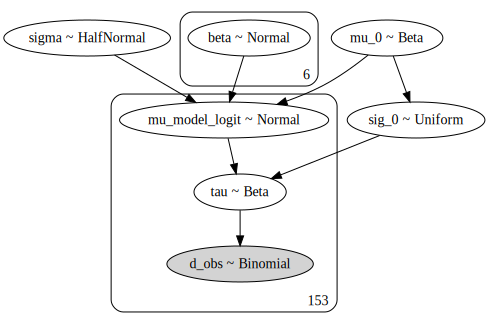

In [119]:
pm.model_to_graphviz(model_2)

In [120]:
trace_2 = train_model.train_model(model_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu_model_logit, sigma, beta, sig_0, mu_0]
Sampling 4 chains, 260 divergences: 100%|██████████| 4000/4000 [01:49<00:00, 11.51draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9331059715598398, but should be close to 0.8. Try to increase the number of tuning steps.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4944682745609237, but should be close to 0.8. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estim

### Other approaches for missing data

It might also be worth looking into the replacing NaN values with zeros, or some other value, rather than just dropping the columns. Or we could drop those rows that have NaNs and just not use those countries' data.

### Model diagnostics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c4630f470>,
      dtype=object)

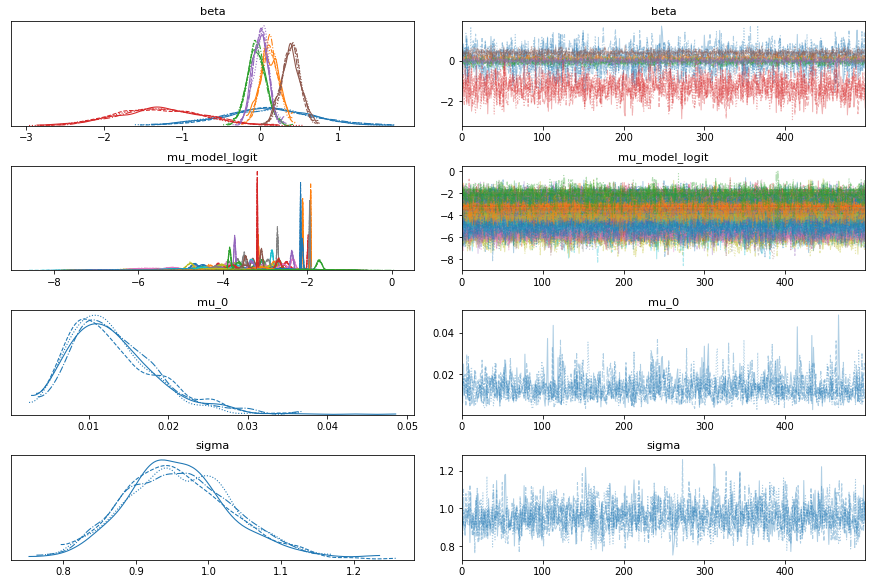

In [112]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c4bb3b898>,
      dtype=object)

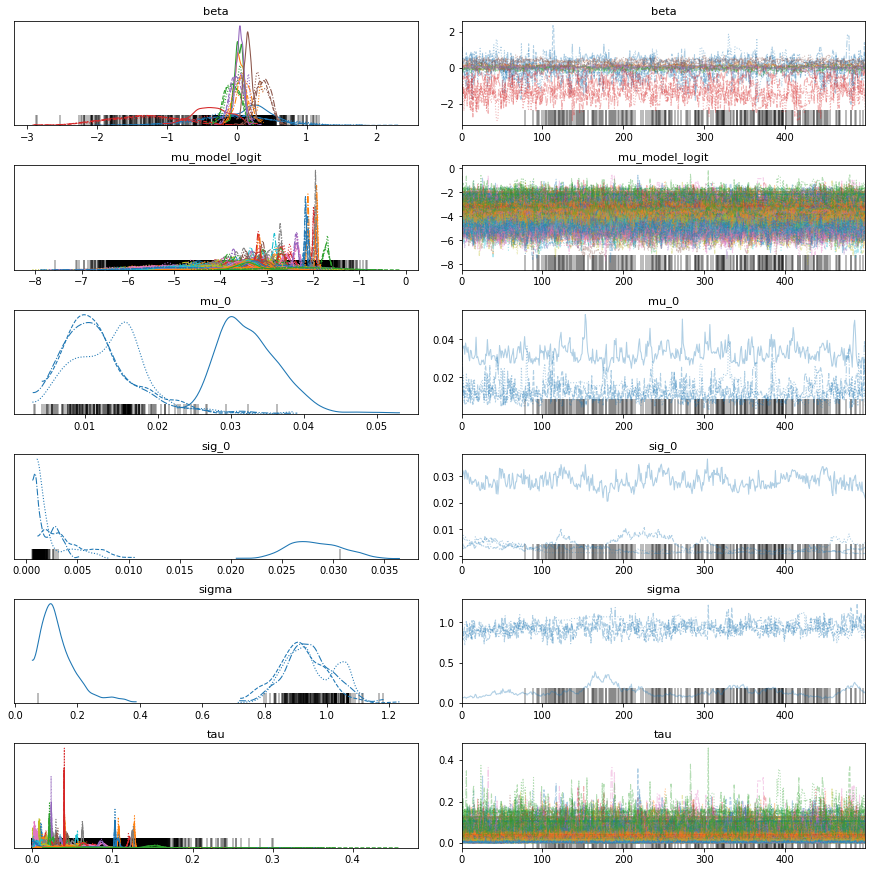

In [121]:
pm.traceplot(trace_2)

In [123]:
pm.summary(trace_2).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],0.03,0.52,-0.99,1.00,0.05,0.04,96.0,96.0,86.0,484.0,1.04
beta[1],0.08,0.12,-0.10,0.34,0.02,0.02,35.0,21.0,43.0,30.0,1.08
beta[2],-0.03,0.11,-0.24,0.15,0.02,0.01,32.0,32.0,36.0,520.0,1.08
beta[3],-1.05,0.64,-2.12,0.09,0.21,0.15,10.0,10.0,9.0,63.0,1.36
beta[4],0.02,0.09,-0.16,0.18,0.01,0.01,67.0,67.0,71.0,95.0,1.05
beta[5],0.32,0.14,0.08,0.55,0.05,0.03,9.0,9.0,9.0,87.0,1.38
mu_model_logit[0],-3.46,0.32,-3.99,-2.87,0.08,0.06,16.0,16.0,14.0,86.0,1.21
mu_model_logit[1],-3.01,0.23,-3.44,-2.57,0.02,0.02,115.0,115.0,94.0,663.0,1.05
mu_model_logit[2],-2.14,0.73,-3.52,-1.56,0.36,0.27,4.0,4.0,7.0,34.0,1.53
mu_model_logit[3],-3.07,0.68,-4.18,-1.72,0.10,0.08,42.0,42.0,51.0,150.0,1.07


In [122]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],0.08,0.56,-1.03,1.12,0.01,0.01,2058.0,1353.0,2061.0,1838.0,1.00
beta[1],0.12,0.12,-0.10,0.35,0.00,0.00,1910.0,1562.0,1906.0,1641.0,1.00
beta[2],-0.05,0.12,-0.26,0.19,0.00,0.00,1851.0,1335.0,1856.0,1545.0,1.00
beta[3],-1.31,0.54,-2.38,-0.40,0.01,0.01,1858.0,1844.0,1862.0,1536.0,1.00
beta[4],0.00,0.10,-0.20,0.17,0.00,0.00,2368.0,1318.0,2378.0,1783.0,1.00
beta[5],0.39,0.12,0.16,0.60,0.00,0.00,2054.0,2009.0,2066.0,1769.0,1.00
mu_model_logit[0],-3.51,0.23,-3.97,-3.10,0.00,0.00,5681.0,5520.0,5751.0,1565.0,1.01
mu_model_logit[1],-2.95,0.21,-3.33,-2.58,0.00,0.00,4374.0,4256.0,4411.0,1648.0,1.00
mu_model_logit[2],-1.72,0.06,-1.84,-1.60,0.00,0.00,4718.0,4697.0,4736.0,1557.0,1.00
mu_model_logit[3],-3.00,0.71,-4.30,-1.69,0.01,0.01,4298.0,3468.0,4420.0,1481.0,1.00


(0.0, 0.05)

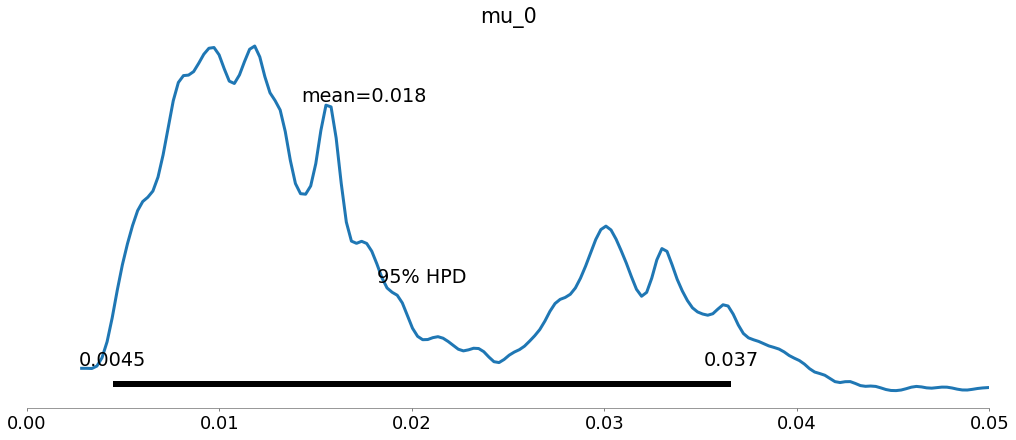

In [124]:
# Posterior plot for mu0
pm.plot_posterior(trace_2, var_names=['mu_0'], figsize=(14, 6), textsize=18,
                  credible_interval=0.95, bw=1.0, lw=3, kind='kde')
plt.xlim(0.0, 0.05)

(0.0, 0.05)

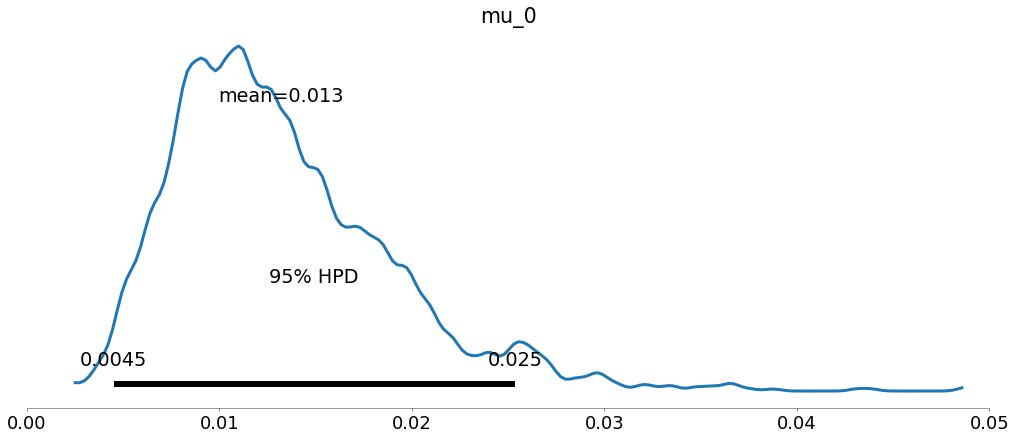

In [125]:
# Posterior plot for mu0
pm.plot_posterior(trace, var_names=['mu_0'], figsize=(14, 6), textsize=18,
                  credible_interval=0.95, bw=1.0, lw=3, kind='kde')
plt.xlim(0.0, 0.05)

### Divergences

In [115]:
# Display the total number and percentage of divergent chains
diverging = trace['diverging']
print('Number of Divergent Chains: {}'.format(diverging.nonzero()[0].size))
diverging_pct = diverging.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent Chains: {:.1f}'.format(diverging_pct))

Number of Divergent Chains: 0
Percentage of Divergent Chains: 0.0


### Model comparison

In [130]:
comp_LOO = pm.compare({model_2: trace_2, model: trace}, ic='LOO')

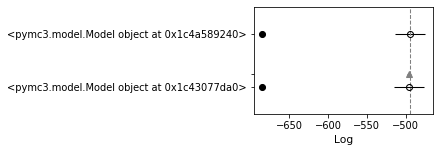

In [131]:
pm.compareplot(comp_LOO);

### Posterior predictive checks

In [132]:
ppc_orig = pm.sample_posterior_predictive(trace_2, samples=500, model=model_2)

100%|██████████| 500/500 [00:00<00:00, 2113.25it/s]


In [133]:
ppc_simplified = pm.sample_posterior_predictive(trace, samples=500, model=model)

100%|██████████| 500/500 [00:00<00:00, 1519.12it/s]


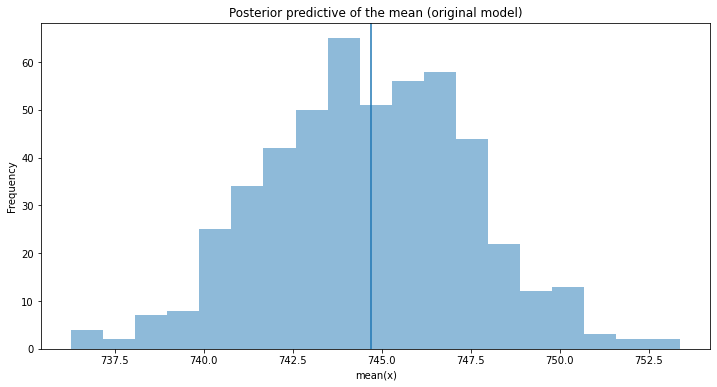

In [136]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc_orig['d_obs']], bins=19, alpha=0.5)
ax.axvline(df['deaths'].values.mean())
ax.set(title='Posterior predictive of the mean (original model)', xlabel='mean(x)', ylabel='Frequency');

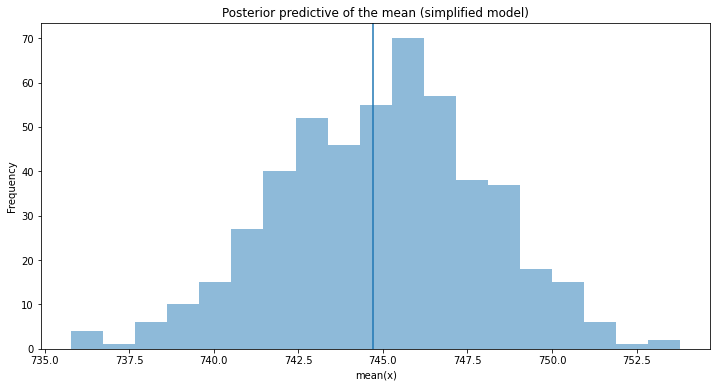

In [138]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc_simplified['d_obs']], bins=19, alpha=0.5)
ax.axvline(df['deaths'].values.mean())
ax.set(title='Posterior predictive of the mean (simplified model)', xlabel='mean(x)', ylabel='Frequency');